In [1]:
"""
Process JSON file written by google benchmarks in various ways:

* create one PNG for every benchmark

    %(prog)s plot result.json

* create a Jupyter notebook with the benchmark plots.
  Note: the benchmark does not contain the generated plots,
  the notebook needs to be executed by a Jupyter kernel first.

    %(prog)s notebook result.json -o my_notebook.ipynb
    jupyter nbconvert --to notebook --execute --inplace my_notebook

* Create a template of README.md used to enrich generated notebook

    %(prog)s readme result.json
    Edit README.md to replace/remove FIXMEs
    %(prog)s notebook -r README.md -o my_notebook.ipynb result.json
"""
import argparse
from collections import Mapping, namedtuple
import copy
import io
from pprint import pprint
import json
import sys

import humanize


class Cache(namedtuple("Cache", ["type", "level", "size", "num_sharing"])):
    @staticmethod
    def from_json(data):
        return Cache(**data)


class Context(
    namedtuple(
        "Context",
        [
            "date",
            "library_build_type",
            "executable",
            "mhz_per_cpu",
            "num_cpus",
            "cpu_scaling_enabled",
            "caches",
        ],
    )
):
    @staticmethod
    def from_json(data):
        caches = [Cache.from_json(cache) for cache in data.pop("caches")]
        return Context(caches=caches, **data)


class Line(namedtuple("Line", ["name", "values", "timings"])):
    """Plot line"""
    pass


class Benchmark(namedtuple("Benchmark", ["raw_title", "lines", "max_timing"])):
    """One benchmark made of several lines"""
    @property
    def title(self):
        """Benchmark title from C++ function name"""
        return self.raw_title.replace("_", " ").capitalize()

    @property
    def time_unit(self):
        """FIXME: adapt according to lines data"""
        return "ms"

    @property
    def xticks(self):
        ticks = set()
        for line in self.lines:
            for value in line.values:
                ticks.add(value)
        ticks = sorted(list(ticks))
        return ticks

    @property
    def xticklabels(self):
        return [humanize.naturalsize(xtick, gnu=True) for xtick in self.xticks]

    @staticmethod
    def from_json(title, benchmarks):
        """Create an instance of this class based on data on JSON

        Args:
            title: first part of the C++ function name
            benchmarks(list of dict): benchmark data, one per line to plot
        """
        lines = dict()
        max_timing = 0
        for benchmark in benchmarks:
            name, value = benchmark["name"].split("__", 1)[1].split("/", 1)
            timing = benchmark["real_time"]
            if timing > max_timing:
                max_timing = timing
            time_unit = benchmark["time_unit"]
            if time_unit != "ns":
                raise Exception("Unexpected 'time_unit': " + time_unit)
            line = lines.setdefault(name, Line(name=name, values=[], timings=[]))
            line.values.append(int(value))
            line.timings.append(timing / 1e6)
        return Benchmark(
            raw_title=title, lines=lines.values(), max_timing=max_timing
        )

    def plot(self):
        self.fig()

    def fig(self):
        import matplotlib.pyplot as plt

        fig, ax = plt.subplots(1, 1, figsize=(12, 6))
        ax.set_title(self.title)
        ax.set_xlabel("elements")
        ax.xscale = "log"
        ax.set_ylabel("time (" + self.time_unit + ")")
        ax.set_xticks(self.xticks)
        ax.set_xticklabels(self.xticklabels)
        for line in self.lines:
            ax.plot(line.values, line.timings, marker="o", label=line.name)
        ax.legend()
        return fig


def group_benchmarks(data):
    result = dict()
    for benchmark in data:
        title = benchmark["name"].split("__", 1)[0]
        result.setdefault(title, []).append(benchmark)
    return {
        title: Benchmark.from_json(title, benchmarks)
        for title, benchmarks in result.items()
    }


def load_from_data(data):
    context = Context.from_json(data["context"])
    benchmarks = group_benchmarks(data["benchmarks"])
    return context, benchmarks




In [2]:
_, benchmarks = load_from_data({'benchmarks': [{'cpu_time': 105303253.60000001,
                 'iterations': 5,
                 'name': 'ascending_insertion__stdmap/524288',
                 'real_time': 105331768.65428686,
                 'time_unit': 'ns'},
                {'cpu_time': 236553936.66666666,
                 'iterations': 3,
                 'name': 'ascending_insertion__stdmap/1048576',
                 'real_time': 236550407.32895336,
                 'time_unit': 'ns'},
                {'cpu_time': 1402480535.0000005,
                 'iterations': 1,
                 'name': 'ascending_insertion__stdmap/4194304',
                 'real_time': 1402638568.0772364,
                 'time_unit': 'ns'},
                {'cpu_time': 2985143212.0,
                 'iterations': 1,
                 'name': 'ascending_insertion__stdmap/8388608',
                 'real_time': 2985115864.7798004,
                 'time_unit': 'ns'},
                {'cpu_time': 43838729.29411769,
                 'iterations': 17,
                 'name': 'ascending_insertion__stdunordered/524288',
                 'real_time': 43838069.9385615,
                 'time_unit': 'ns'},
                {'cpu_time': 87310325.99999999,
                 'iterations': 9,
                 'name': 'ascending_insertion__stdunordered/1048576',
                 'real_time': 87308979.85191809,
                 'time_unit': 'ns'},
                {'cpu_time': 311310643.99999976,
                 'iterations': 2,
                 'name': 'ascending_insertion__stdunordered/4194304',
                 'real_time': 311305692.88507104,
                 'time_unit': 'ns'},
                {'cpu_time': 629576979.0000012,
                 'iterations': 1,
                 'name': 'ascending_insertion__stdunordered/8388608',
                 'real_time': 629578249.0633428,
                 'time_unit': 'ns'},
                {'cpu_time': 13394597.641509421,
                 'iterations': 53,
                 'name': 'ascending_insertion__flatmap/524288',
                 'real_time': 13394623.151365316,
                 'time_unit': 'ns'},
                {'cpu_time': 26726656.115384616,
                 'iterations': 26,
                 'name': 'ascending_insertion__flatmap/1048576',
                 'real_time': 26726438.681809947,
                 'time_unit': 'ns'},
                {'cpu_time': 134798919.60000002,
                 'iterations': 5,
                 'name': 'ascending_insertion__flatmap/4194304',
                 'real_time': 134797699.56320524,
                 'time_unit': 'ns'},
                {'cpu_time': 293244855.50000024,
                 'iterations': 2,
                 'name': 'ascending_insertion__flatmap/8388608',
                 'real_time': 293248573.55095446,
                 'time_unit': 'ns'},
                {'cpu_time': 342853.1973555334,
                 'iterations': 2042,
                 'name': 'ascending_insertion__flatmap_ctor/524288',
                 'real_time': 342850.4107671404,
                 'time_unit': 'ns'},
                {'cpu_time': 706456.1703853961,
                 'iterations': 986,
                 'name': 'ascending_insertion__flatmap_ctor/1048576',
                 'real_time': 706445.8729914611,
                 'time_unit': 'ns'},
                {'cpu_time': 9422630.081081111,
                 'iterations': 74,
                 'name': 'ascending_insertion__flatmap_ctor/4194304',
                 'real_time': 9422485.647421028,
                 'time_unit': 'ns'},
                {'cpu_time': 20368503.29411762,
                 'iterations': 34,
                 'name': 'ascending_insertion__flatmap_ctor/8388608',
                 'real_time': 20368603.893610485,
                 'time_unit': 'ns'},
                {'cpu_time': 222949542.33333305,
                 'iterations': 3,
                 'name': 'unordered_insertion__stdmap/524288',
                 'real_time': 222948261.07099652,
                 'time_unit': 'ns'},
                {'cpu_time': 555182813.0000018,
                 'iterations': 1,
                 'name': 'unordered_insertion__stdmap/1048576',
                 'real_time': 555179545.1901853,
                 'time_unit': 'ns'},
                {'cpu_time': 3780483025.999999,
                 'iterations': 1,
                 'name': 'unordered_insertion__stdmap/4194304',
                 'real_time': 3780435070.8611307,
                 'time_unit': 'ns'},
                {'cpu_time': 10085699953.999998,
                 'iterations': 1,
                 'name': 'unordered_insertion__stdmap/8388608',
                 'real_time': 10085561431.94437,
                 'time_unit': 'ns'},
                {'cpu_time': 1982255614.9999998,
                 'iterations': 1,
                 'name': 'unordered_insertion__stdunordered/524288',
                 'real_time': 1982238669.8797345,
                 'time_unit': 'ns'},
                {'cpu_time': 194356913.33333218,
                 'iterations': 3,
                 'name': 'unordered_insertion__stdunordered/1048576',
                 'real_time': 194356307.69779286,
                 'time_unit': 'ns'},
                {'cpu_time': 1331668086.9999971,
                 'iterations': 1,
                 'name': 'unordered_insertion__stdunordered/4194304',
                 'real_time': 1331663472.5779295,
                 'time_unit': 'ns'},
                {'cpu_time': 2388655170.0,
                 'iterations': 1,
                 'name': 'unordered_insertion__stdunordered/8388608',
                 'real_time': 2388636041.89828,
                 'time_unit': 'ns'},
                {'cpu_time': 25173835489.0,
                 'iterations': 1,
                 'name': 'unordered_insertion__flatmap/524288',
                 'real_time': 25173857116.140427,
                 'time_unit': 'ns'},
                {'cpu_time': 108965298005.00002,
                 'iterations': 1,
                 'name': 'unordered_insertion__flatmap/1048576',
                 'real_time': 108965294302.90685,
                 'time_unit': 'ns'},
                {'cpu_time': 447506645088.0,
                 'iterations': 1,
                 'name': 'unordered_insertion__flatmap/2097152',
                 'real_time': 447506544874.04974,
                 'time_unit': 'ns'},
                {'cpu_time': 15286369.521739118,
                 'iterations': 46,
                 'name': 'iteration__stdmap/524288',
                 'real_time': 15286199.65740844,
                 'time_unit': 'ns'},
                {'cpu_time': 45759970.59999964,
                 'iterations': 15,
                 'name': 'iteration__stdmap/1048576',
                 'real_time': 45767440.55375457,
                 'time_unit': 'ns'},
                {'cpu_time': 220123374.0000011,
                 'iterations': 3,
                 'name': 'iteration__stdmap/4194304',
                 'real_time': 220120554.4794599,
                 'time_unit': 'ns'},
                {'cpu_time': 420375237.99999833,
                 'iterations': 2,
                 'name': 'iteration__stdmap/8388608',
                 'real_time': 420369223.9243537,
                 'time_unit': 'ns'},
                {'cpu_time': 109639946.19999652,
                 'iterations': 5,
                 'name': 'iteration__stdunordered/524288',
                 'real_time': 109637983.32959414,
                 'time_unit': 'ns'},
                {'cpu_time': 332981300.8888891,
                 'iterations': 9,
                 'name': 'iteration__stdunordered/1048576',
                 'real_time': 332976090.98048675,
                 'time_unit': 'ns'},
                {'cpu_time': 497381684.49999166,
                 'iterations': 2,
                 'name': 'iteration__stdunordered/4194304',
                 'real_time': 497373984.195292,
                 'time_unit': 'ns'},
                {'cpu_time': 667209525.9999934,
                 'iterations': 1,
                 'name': 'iteration__stdunordered/8388608',
                 'real_time': 667205550.2422154,
                 'time_unit': 'ns'},
                {'cpu_time': 810.8279883154123,
                 'iterations': 861046,
                 'name': 'iteration__flatmap/524288',
                 'real_time': 980.3296581006523,
                 'time_unit': 'ns'},
                {'cpu_time': 882.0767998068674,
                 'iterations': 795262,
                 'name': 'iteration__flatmap/1048576',
                 'real_time': 1138.759960450159,
                 'time_unit': 'ns'},
                {'cpu_time': 254829.50072386308,
                 'iterations': 2766,
                 'name': 'iteration__flatmap/4194304',
                 'real_time': 255111.3870816436,
                 'time_unit': 'ns'},
                {'cpu_time': 356909.5262609283,
                 'iterations': 1961,
                 'name': 'iteration__flatmap/8388608',
                 'real_time': 357119.255157331,
                 'time_unit': 'ns'},
                {'cpu_time': 22280299.45163437,
                 'iterations': 31,
                 'name': '_512K random_lookup__stdmap/524288',
                 'real_time': 22280009.343258794,
                 'time_unit': 'ns'},
                {'cpu_time': 39797936.89474096,
                 'iterations': 19,
                 'name': '_512K random_lookup__stdmap/1048576',
                 'real_time': 39797610.26015407,
                 'time_unit': 'ns'},
                {'cpu_time': 128131806.80009282,
                 'iterations': 5,
                 'name': '_512K random_lookup__stdmap/4194304',
                 'real_time': 128130217.36219525,
                 'time_unit': 'ns'},
                {'cpu_time': 233739020.99986783,
                 'iterations': 3,
                 'name': '_512K random_lookup__stdmap/8388608',
                 'real_time': 233735727.7671496,
                 'time_unit': 'ns'},
                {'cpu_time': 14301598.854155866,
                 'iterations': 48,
                 'name': '_512K random_lookup__stdunordered/524288',
                 'real_time': 14301322.138635442,
                 'time_unit': 'ns'},
                {'cpu_time': 27100346.269207876,
                 'iterations': 26,
                 'name': '_512K random_lookup__stdunordered/1048576',
                 'real_time': 27100054.493460517,
                 'time_unit': 'ns'},
                {'cpu_time': 84955515.00002627,
                 'iterations': 11,
                 'name': '_512K random_lookup__stdunordered/4194304',
                 'real_time': 84955170.83528367,
                 'time_unit': 'ns'},
                {'cpu_time': 152985848.83335784,
                 'iterations': 6,
                 'name': '_512K random_lookup__stdunordered/8388608',
                 'real_time': 152984579.6370258,
                 'time_unit': 'ns'},
                {'cpu_time': 3569013.1785648707,
                 'iterations': 196,
                 'name': '_512K random_lookup__flatmap/524288',
                 'real_time': 3569025.453655239,
                 'time_unit': 'ns'},
                {'cpu_time': 3849340.884601458,
                 'iterations': 182,
                 'name': '_512K random_lookup__flatmap/1048576',
                 'real_time': 3849420.3434131304,
                 'time_unit': 'ns'},
                {'cpu_time': 4156715.2916516513,
                 'iterations': 168,
                 'name': '_512K random_lookup__flatmap/4194304',
                 'real_time': 4156929.9064576626,
                 'time_unit': 'ns'},
                {'cpu_time': 4531231.696779697,
                 'iterations': 155,
                 'name': '_512K random_lookup__flatmap/8388608',
                 'real_time': 4531430.89769348,
                 'time_unit': 'ns'}],
 'context': {'caches': [{'level': 1,
                         'num_sharing': 2,
                         'size': 32000000,
                         'type': 'Data'},
                        {'level': 1,
                         'num_sharing': 2,
                         'size': 32000000,
                         'type': 'Instruction'},
                        {'level': 2,
                         'num_sharing': 2,
                         'size': 1024000000,
                         'type': 'Unified'},
                        {'level': 3,
                         'num_sharing': 36,
                         'size': 25344000000,
                         'type': 'Unified'}],
             'cpu_scaling_enabled': False,
             'date': '2019-04-15 10:06:30',
             'executable': './map_benchmark',
             'library_build_type': 'release',
             'mhz_per_cpu': 3700,
             'num_cpus': 72}}
)


## Context

Run on (72 X 3700 MHz CPUs) on BB5 CPU node  
CPU Caches
* L1 Data 32000000 (x 2)
* L1 Instruction 32000000 (x 2)
* L2 Unified 1024000000 (x 2)
* L3 Unified 25344000000 (x 36)

Tested types:

* *stdmap*: `std::map`
* *stdunordered*: `std::unordered_map`
* *flatmap*: `boost::container::flat_map`

Both keys and values are 32bits integers.


## Ascending insertion

Insert an ordered collection of key/value pairs, for instance:

```cpp
std::vector<std::pair<int, int>> v{
    {1, 1},
    {2, 1},
    {3, 1}
    // ...
};
```

*flatmap_ctor* line uses `flat_map(ordered_unique_range_t, InputIterator, InputIterator)`
optimized constructor that assumes the input iterator is sorted.


In [3]:
benchmarks['ascending_insertion'].plot()


## Unordered insertion

Insert random keys in the containers.



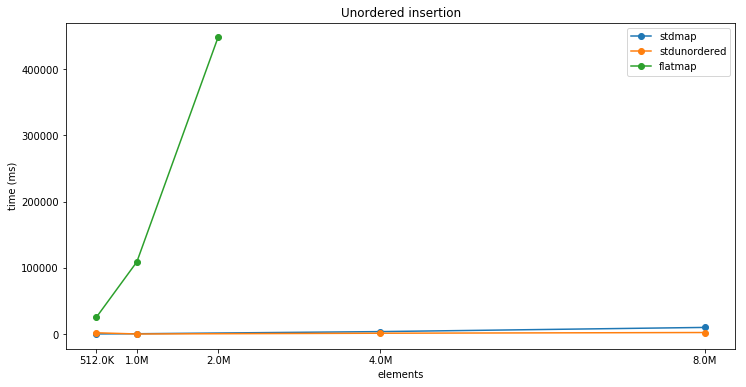

In [4]:
benchmarks['unordered_insertion'].plot()



We can observe that the *flat_map* keeps reordering the elements of the vector during insertions
of random values, which leads to very poor performance.   


## Iteration

Iterate over the entire collection.


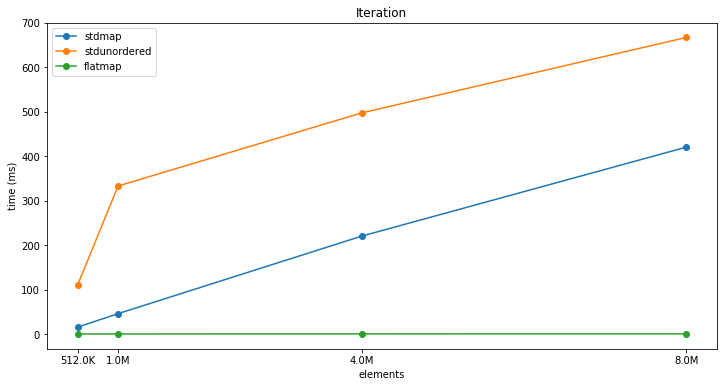

In [5]:
benchmarks['iteration'].plot()


##  512k random lookup

After creating the containers,  measure the time required to perform 512k random lookups.


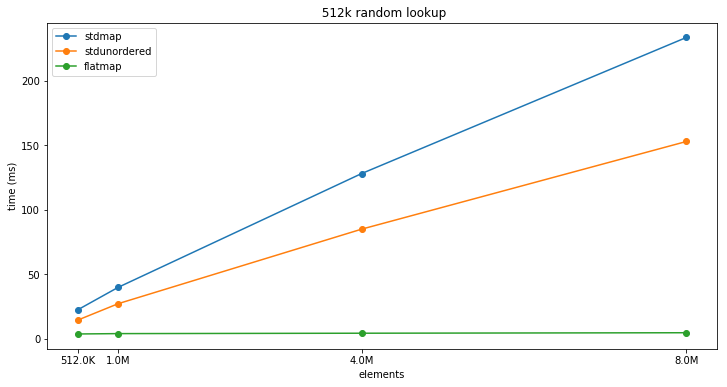

In [6]:
benchmarks['_512K random_lookup'].plot()
